[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and **allows users to interact directly with graphs in various ways.**

To set the stage for `human-in-the-loop`, we'll first dive into `streaming`, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Note that we use `RunnableConfig` with `call_model` to **enable token-wise streaming**. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

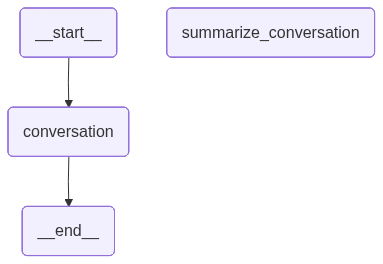

In [ ]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig # to enable token-wise streaming (Python < 3.11)

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

# State 
class State(MessagesState): # 'messages' is built-in
    summary: str # custom key for chat summary

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig): # For python > 3.11, the runtime natively supports async/await streaming, so you don’t need RunnableConfig. The function can just take 'state'
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png())) # this is drawing the wrong graph at the moment...

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

##### Because we stream with `updates`, we only see updates to the state after node in the graph is run.

> Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CJz4UvqzAtGp5GxpIWmCnnDwnDFrX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8d80175f-c691-46d0-a73c-d4b8bea25ea5-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Because you’re streaming in `updates` mode, **each chunk is just the delta: what changed in the state after one node ran.**

> Here, the change is: “AI produced one new message”. That’s why you only see this new AIMessage in the output, not the whole history.

Let's now just print the state update.

In [ ]:
# Start conversation with stream_mode="updates"
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi again, Lance! What would you like to talk about?


Now, let's see `stream_mode="values"`.

##### This is the `full state` of the graph after the `conversation` node is called.

In [7]:
# Start conversation with stream_mode="values" (in a new clean thread)
config = {"configurable": {"thread_id": "2"}}

input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! How can I assist you today?
---------------------------------------------------------------------------


### Why does the message appear twice with `stream_mode="values"`?

When using **`stream_mode="values"`**, LangGraph emits the **entire graph state** after each node finishes execution.  [a,b]

This is different from **`stream_mode="updates"`**, which only emits the *deltas* (changes since the last step). [b]

- **First emission**: after the human message is recorded →  
  State = `[HumanMessage("hi! I'm Lance")]`.

- **Second emission**: after the model runs →  
  State = `[HumanMessage("hi! I'm Lance"), AIMessage("Hi Lance! How can I assist you today?")]`.

Because `values` mode shows the **full state snapshot** at each step, the same human message appears again, but it’s not duplicated in memory — it’s just re-emitted as part of the updated state.

---

✅ **Use `updates` mode** when you only care about incremental changes (efficient).  
✅ **Use `values` mode** when you want to debug or inspect the entire state of the conversation after each step.


### Streaming tokens

We often want to stream more than graph state.

##### In particular, with chat model calls it is common to stream the tokens as they are generated.

##### We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [14]:
# start conversation in a new clean thread , streaming tokens as they are generated
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

# stream events as they happen inside nodes!
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")
    print(f"==full event: {event}\n")

Node: . Type: on_chain_start. Name: LangGraph
==full event: {'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '234bceae-9584-4cdf-b174-848a109ed6f9', 'metadata': {'thread_id': '3'}, 'parent_ids': []}

Node: conversation. Type: on_chain_start. Name: conversation
==full event: {'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={}, id='09be62d7-12b7-4190-bed0-4c19795296d0'), AIMessage(content='The San Francisco 49ers are a professional American football team based in San Francisco, California. They are a member of the National Football League (NFL) and compete in the league\'s National Football Conference (NFC) West division. Here are some key points about the team:\n\n### History\n- **Founded**: The 49ers were established in 194

In [ ]:
# start conversation in a new clean thread , streaming tokens as they are generated
config = {"configurable": {"thread_id": "999"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team in at most 20 words")

# stream events as they happen inside nodes and printing each generated token
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(event)
    if event['event'] == 'on_chat_model_stream':
        print(f"===GENERATED TOKEN: {event['data']['chunk'].content}\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team in at most 20 words', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '621b1603-6f65-40d8-8de7-038e46715984', 'metadata': {'thread_id': '999'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team in at most 20 words', additional_kwargs={}, response_metadata={}, id='af93c3bc-d1c7-4395-9be0-4868c4085fbd'), AIMessage(content='The San Francisco 49ers are a successful NFL team with five Super Bowl titles, known for legendary players and passionate fans.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'service_tier': 'default'}, id='run--da7a5c82-b89e-4bd5-a634-39c9f6ed4ec7'), HumanMessage(content='Tell me about the 49ers NFL team in at most 20 words', additio

##### The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

#### We can use `event['metadata']['langgraph_node']` to select the node to stream from.

#### And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [15]:
# define which node to stream
node_to_stream = 'conversation'

# start new conversation in a clean thread
config = {"configurable": {"thread_id": "4"}}

# send message to graph
input_message = HumanMessage(content="Tell me about the 49ers NFL team in 20 words.")

# stream events from graph
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node (node_to_stream)
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--10d7feaf-165f-43d8-9347-25811397dfd5')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--10d7feaf-165f-43d8-9347-25811397dfd5')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run--10d7feaf-165f-43d8-9347-25811397dfd5')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run--10d7feaf-165f-43d8-9347-25811397dfd5')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--10d7feaf-165f-43d8-9347-25811397dfd5')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run--10d7feaf-165f-43d8-9347-25811397dfd5')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run--10d7feaf-165f-43d8-9347-25811397dfd5')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, respons

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [16]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|") # end="|" is used to print a delimiter between chunks

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| San| Francisco|,| California|.| They| are| a| member| of| the| National| Football| League| (|NFL|)| and| compete| in| the| league|'s| National| Football| Conference| (|N|FC|)| West| division|.| Here| are| some| key| points| about| the| team|:

|###| History|
|-| **|Founded|**|:| The| |49|ers| were| established| in| |194|6| as| a| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| before| joining| the| NFL| in| |194|9|.
|-| **|Name| Origin|**|:| The| team's| name| refers| to| the| prospect|ors| who| flock|ed| to| California| during| the| Gold| Rush| of| |184|9|.

|###| Ach|ievements|
|-| **|Super| Bowl| Championships|**|:| The| |49|ers| have| won| five| Super| Bowl| titles| (|X|VI|,| XIX|,| XX|III|,| XX|IV|,| and| XX|IX|),| making| them| one| of| the| most| successful| franchises| in| NFL| history|.
|-| **|Hall| of| Fam|ers|**|:| The| team| has| produced| numerous| Hall| of| Fame| pla

### Streaming with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [17]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [19]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {'configurable': {}},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2025-09-26T10:31:16.602086+00:00',
  'updated_at': '2025-09-26T10:31:16.602086+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {'configurable': {}},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-09-26T10:31:16.593652+00:00',
  'updated_at': '2025-09-26T10:31:16.593652+00:00',
  'version': 1,
  'description': None}]

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [20]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '01998594-782b-7216-881f-191037cfb468', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '65fc9a0c-70b3-44dd-9849-7157e1bd3e1f', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '65fc9a0c-70b3-44dd-9849-7157e1bd3e1f', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_8rXs1LCbYVOYDuCCQnBNWv12', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_

The streamed objects have: 

* `event`: Type
* `data`: State

In [21]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='e3b322d3-c300-4b67-a58e-50ff377b4cca'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_PT3TJHdHnvPKSUInjd1dQiNi', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CK02RSOd9DwvKxQPY2Ljbxf5VYyDO', 'service_tier': 'default', 'finish_reason': 'too

There are some **new streaming mode that are only supported via the API**.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

##### This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"): # new stream mode via the API
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent", # 'agent' graph 
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 01998597-b329-7164-8c8a-796f738c137a
--------------------------------------------------
Tool Calls:
Tool Call ID: call_OzszfB2onNUO5NWgtKdfGDLX, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_OzszfB2onNUO5NWgtKdfGDLX, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_OzszfB2onNUO5NWgtKdfGDLX, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_OzszfB2onNUO5NWgtKdfGDLX, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_OzszfB2onNUO5NWgtKdfGDLX, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_OzszfB2onNUO5NWgtKdfGDLX, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

### Streaming Tool Calls and Responses

When streaming with `client.runs.stream(..., stream_mode="messages")`, events arrive incrementally:

1. **Metadata event**  
   Prints the run ID so you can track the execution.

2. **Tool call streaming**  
   The assistant decides to call `multiply`. Tool calls are streamed *partially*, so you see the same call id repeated:
   - `Arguments: {}` (empty)  
   - `Arguments: {'a': 2}`  
   - `Arguments: {'a': 2, 'b': 3}`
     
   This is why the output looks “duplicated”—it’s actually showing the arguments being filled step by step until `finish_reason = tool_calls`.

3. **Tool execution**  
   The runtime executes `multiply(a=2, b=3)` and gets the result `6`.

4. **Final answer streaming**  
   The assistant streams its reply token by token:  
The → The result → The result of multiplying 2 and 3 is 6.

Each partial chunk is printed as it arrives, until `finish_reason = stop`.

**Conclusion:**  
You see duplicate-looking tool calls because arguments are streamed incrementally, and you see fragmented sentences because the assistant’s final message is streamed token by token.
